In [1]:
#Questions: Are the different coefficients uniform amongst all the nodes in the graph ? Right now, they are equal for all nodes. 
# Yes they should be equal since we are assuming that the effect is shared and we just variate over the value of the feature.
#To easily compute and update the happiness, we keep the following properties true during the evolution of the graph:
# - the attribute contains the happiness of the current node at each step
# - at the begining of a step, the attribute 'happiness_updating' contains coeff_X*X + coeff_Z*Z + coeff_previous_happiness*happiness.
#Therefore we only have to add the influence of all the other nodes at 'happiness_updating' to obtain the updated happiness.

#Here, at each step, we choose a random node and add one friend to it. Then update the happiness of everyone.

In [2]:
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import scipy
import random
import math
import pandas as pd
from sklearn.linear_model import LogisticRegression
import statsmodels.formula.api as sm

In [3]:
#Defining our global variables:
N_nodes = 100
#This is the rate of updated nodes for each run (only 30% of the nodes will have a new friend per run here for instance)
rate_updated_nodes_per_run = 0.3

In [4]:
#Defining graph
G=nx.DiGraph()
G.add_nodes_from(range(N_nodes))

In [5]:
#Defining attributes
for i in range(N_nodes):
    G.node[i]['X'] = random.random()*2.0-1.0
    G.node[i]['Z'] = 0*random.random()*2.0-1.0
    G.node[i]['coeff_X'] = 0.5
    G.node[i]['coeff_Z'] = 0.8
    G.node[i]['coeff_previous_happiness'] = 0.1
    G.node[i]['coeff_influence'] = 2
    G.node[i]['happiness'] = [G.node[i]['X'] * G.node[i]['coeff_X'] + G.node[i]['Z'] * G.node[i]['coeff_Z']]
    G.node[i]['happiness_updating'] = G.node[i]['X'] * G.node[i]['coeff_X'] + G.node[i]['Z'] * G.node[i]['coeff_Z']+ G.node[i]['coeff_previous_happiness']* G.node[i]['happiness'][0]

In [6]:
#Creating similarity matrices
similarity_matrix = [[0 for i in range(N_nodes)] for j in range(N_nodes)]
observable_matrix = [[0 for i in range(N_nodes)] for j in range(N_nodes)]
similarity_coefficient = 3
for i in range(N_nodes):
    for j in range(i):
        similarity_matrix[i][j] = -similarity_coefficient*math.sqrt((G.node[i]['X'] - G.node[j]['X'])**2 + (G.node[i]['Z'] - G.node[j]['Z'])**2)
        observable_matrix[i][j] = math.sqrt((G.node[i]['X'] - G.node[j]['X'])**2) 
        similarity_matrix[i][j] = 1.0 / (1.0 + math.exp(-similarity_matrix[i][j]))
        similarity_matrix[j][i] = similarity_matrix[i][j]
        observable_matrix[j][i] = observable_matrix[i][j]
        


In [7]:
#Creating set of potential friends for each node
def create_list_potential_friends(Graph):
    list_potential_friends = [[] for i in range(N_nodes)]
    for i in range(N_nodes):
        for j in range(N_nodes):
            if i != j and (i,j) not in Graph.edges():
                if random.random() < similarity_matrix[i][j]:
                    list_potential_friends[i].append(j)
    return list_potential_friends

global list_potential_friends
list_potential_friends = create_list_potential_friends(G)

In [8]:
#Function to add to the node "node" a random friend from his list of friends (and to remove him from the list)
def add_one_friend(node, Graph, idx_step):
    if len(list_potential_friends[node])>0:
        new_friend = random.choice(list_potential_friends[node])
        Graph.add_edge(node, new_friend, step_creation = idx_step)

In [9]:
#This step is made to add a friend for each node of the Graph
def init_step(Graph, idx_step):   
    global list_potential_friends
    for node in range(N_nodes):
        add_one_friend(node, Graph, idx_step)
    update_happiness(Graph)
    list_potential_friends = create_list_potential_friends(Graph)

In [10]:
#Update happiness 
def update_happiness(Graph):
    for (a,b) in Graph.edges_iter():
        Graph.node[a]['happiness_updating'] +=  Graph.node[a]['coeff_influence'] *Graph.node[b]['happiness'][-1]/len(Graph.neighbors(a))
    for i in range(N_nodes):
        Graph.node[i]['happiness'].append(Graph.node[i]['happiness_updating'])
        Graph.node[i]['happiness_updating'] = Graph.node[i]['coeff_previous_happiness']*Graph.node[i]['happiness'][-1] + Graph.node[i]['X'] * Graph.node[i]['coeff_X'] + Graph.node[i]['Z'] * Graph.node[i]['coeff_Z']

In [11]:
def run_step(Graph, idx_step):
    global list_potential_friends
    for node in range(N_nodes):
        if random.random() < rate_updated_nodes_per_run:
            add_one_friend(node, Graph, idx_step)
    update_happiness(Graph)
    list_potential_friends = create_list_potential_friends(Graph)

In [12]:
def compute_real_effect(Graph):
    matrix_res = [[0. for j in range(N_nodes)] for i in range(N_nodes)]
    for i in range(N_nodes):
        if Graph.out_degree(i) ==1:
            for k in nx.all_neighbors(Graph,i):
                new_friend=k
                new_additional_happiness_no_new_friend = Graph.node[k]['happiness'][-1]*G.node[i]['coeff_influence']/2.
            for j in nx.non_neighbors(Graph,i): 
                if Graph.node[j]['happiness'][-1] > Graph.node[i]['happiness'][-1]:
                    new_additional_happiness_with_new_friend_j = Graph.node[j]['happiness'][-1]*Graph.node[i]['coeff_influence']/2.
                    matrix_res[i][j] = new_additional_happiness_with_new_friend_j - new_additional_happiness_no_new_friend
        else:
            print "special case: node without " + str(Graph.out_degree(i)) + " friends" 
#     return matrix_res
    res=0.
    count_friends_potentially_added=0
    for i in range(N_nodes):
        for j in range(N_nodes):
            if matrix_res[i][j] >0:
                count_friends_potentially_added += 1.
                res += matrix_res[i][j]
    return res /count_friends_potentially_added

In [13]:
#Main run for the graph
nb_steps=1
init_step(G, 0)
print compute_real_effect(G)
for i in range(nb_steps):
    run_step(G, i+1)

0.976635630253


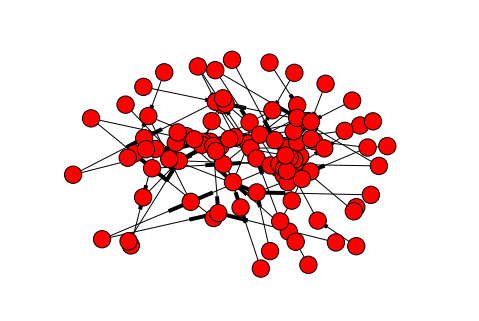

In [14]:
#Plotting the last graph obtained
nx.draw(G)
plt.show()

In [15]:
def create_propensity_table(Graph):
    edges = []
    treatment = []
    response = []
    friends = []
    X1 = []
    X2 = []
    second_friend_happiness = []
    for i in range(N_nodes):
        for j in range(i+1,N_nodes):
            if Graph.node[j]['happiness'][-2]> Graph.node[i]['happiness'][-2]:
                u,v = i,j
            else:
                u,v = j,i
                
            if (u,v) in Graph.edges() and Graph[u][v]['step_creation']==1:
                treatment.append(1)
                second_friend_happiness.append(Graph.node[v]['happiness'][-2])
                edges.append((u,v))
                response.append(Graph.node[u]['happiness'][-1]-Graph.node[u]['happiness'][-2])
                friends.append(sum([Graph.node[w]['happiness'][-2] for w in Graph.neighbors(u) if Graph[u][w]['step_creation']<1 ]))                    
                X1.append(Graph.node[u]['X'])
                X2.append(Graph.node[v]['X'])
            elif len(Graph.neighbors(u))==1 :
                edges.append((u,v))
                treatment.append(0)
                second_friend_happiness.append(0)
                response.append(Graph.node[u]['happiness'][-1]-Graph.node[u]['happiness'][-2])
                friends.append(sum([Graph.node[w]['happiness'][-2] for w in Graph.neighbors(u) ]))                    
                X1.append(Graph.node[u]['X'])
                X2.append(Graph.node[v]['X'])
                
            
                
    return pd.DataFrame({'Edges':edges,
                    'Treatment': treatment,
                    'Response': response,
                    'Friends': friends,
                    'Second':second_friend_happiness,
                    'X1': X1,
                    'X2': X2})

In [16]:
data = create_propensity_table(G)
data['X3'] = abs(data['X2']-data['X1'])
data

,Edges,Friends,Response,Second,Treatment,X1,X2,X3
0,"(0, 1)",-3.017722,-4.311925,0,0,-0.913627,0.554316,1.467943
1,"(0, 2)",-3.017722,-4.311925,0,0,-0.913627,-0.318008,0.595619
2,"(0, 3)",-3.017722,-4.311925,0,0,-0.913627,-0.240469,0.673158
3,"(0, 4)",-3.017722,-4.311925,0,0,-0.913627,0.673261,1.586888
4,"(0, 6)",-3.017722,-4.311925,0,0,-0.913627,-0.425557,0.488070
5,"(0, 7)",-3.017722,-4.311925,0,0,-0.913627,0.711311,1.624938
6,"(0, 8)",-3.017722,-4.311925,0,0,-0.913627,0.199284,1.112910
7,"(0, 9)",-3.017722,-4.311925,0,0,-0.913627,0.178964,1.092591
8,"(0, 10)",-3.017722,-4.311925,0,0,-0.913627,-0.650703,0.262924
9,"(0, 11)",-3.017722,-4.311925,0,0,-0.913627,-0.356780,0.556847


In [17]:
propensity = LogisticRegression()
propensity = propensity.fit(data[['X1','X2','X3']], data.Treatment)
pscore = propensity.predict_proba(data[['X1','X2','X3']])[:,1] # The predicted propensities by the model
data['Propensity'] = [(data['X1'][i],data['X2'][i]) for i in range(len(data['X1']))]


In [18]:
def Match(groups, propensity, caliper = 0.05):
    ''' 
    Inputs:
    groups = Treatment assignments.  Must be 2 groups
    propensity = Propensity scores for each observation. Propensity and groups should be in the same order (matching indices)
    caliper = Maximum difference in matched propensity scores. For now, this is a caliper on the raw
            propensity; Austin reccommends using a caliper on the logit propensity.
    
    Output:
    A series containing the individuals in the control group matched to the treatment group.
    Note that with caliper matching, not every treated individual may have a match.
    '''

    # Check inputs
#     if any(propensity <=0) or any(propensity >=1):
#         raise ValueError('Propensity scores must be between 0 and 1')
#     elif not(0<caliper<1):
#         raise ValueError('Caliper must be between 0 and 1')
#     elif len(groups)!= len(propensity):
#         raise ValueError('groups and propensity scores must be same dimension')
#     elif len(groups.unique()) != 2:
#         raise ValueError('wrong number of groups')
        
        
    # Code groups as 0 and 1
    groups = groups == groups.unique()[0]
    N = len(groups)
    N1 = groups.sum(); N2 = N-N1
    g1, g2 = propensity[groups == 1].reset_index(drop=True), (propensity[groups == 0]).reset_index(drop=True)
    # Check if treatment groups got flipped - treatment (coded 1) should be the smaller
    if N1 > N2:
        N1, N2, g1, g2 = N2, N1, g2, g1 
        
        
    # Randomly permute the smaller group to get order for matching
    morder = np.random.permutation(N1)
    matches = pd.Series(np.empty(N1))
    matches[:] = np.NAN
    
    for m in morder:
        dist = np.array([max(np.abs(np.subtract(g1[m],x))) for x in g2])
        if dist.min() <= caliper:
            matches[m] = int(dist.argmin())
#             g2 = g2.drop(matches[m])
    return (matches)


In [19]:
stuff = Match(data.Treatment, data.Propensity)
g1, g2 = data.Propensity[data.Treatment==1].reset_index(drop=True), data.Propensity[data.Treatment==0].reset_index(drop=True)
stuff


0     2325
1     2325
2      647
3      798
4      477
5      607
6      293
7      275
8     1120
9     1847
10     114
11    1952
12    2110
13     805
14      56
15    2808
dtype: float64

In [20]:
zip(g1, g2[stuff])


[((-0.29265973387063027, -0.31800786156982386),
  (-0.29352307498407071, -0.31653456090047816)),
 ((-0.28938553958787305, -0.31800786156982386),
  (-0.29352307498407071, -0.31653456090047816)),
 ((-0.64658637060803703, -0.17182214279521935),
  (-0.65070313330598872, -0.17182214279521935)),
 ((-0.42555686452628039, -0.92692893784457597),
  (-0.41403299638543611, -0.9350387689246098)),
 ((0.075355572212146393, 0.19928350837670439),
  (0.026422835761784835, 0.19928350837670439)),
 ((-0.3935782416575988, -0.65070313330598872),
  (-0.37920321459119899, -0.65070313330598872)),
 ((-0.2204131862190617, -0.24681012738123354),
  (-0.23059264092643872, -0.24046888962479285)),
 ((-0.9905033376791117, -0.23059264092643872),
  (-0.97727312696628088, -0.24046888962479285)),
 ((-0.82462220187500823, -0.60772621972672836),
  (-0.82403461498117725, -0.60772621972672836)),
 ((0.89144837844074853, 0.90352196120283623),
  (0.90352196120283623, 0.94007496355226983)),
 ((0.55509131742295903, 0.89144837844074

In [21]:
r1 = data[data.Treatment==1].reset_index(drop=True)
r2 = data[data.Treatment==0].reset_index(drop=True)
r1 = r1[[not math.isnan(x) for x in stuff]]
st=[int(x) for x in stuff if not math.isnan(x)]
st
data2 = pd.concat([r1,r2.iloc[st]]).reset_index(drop=True)

print data2

       Edges   Friends  Response    Second  Treatment        X1        X2  \
0    (32, 2) -2.722084 -3.939393 -2.802486          1 -0.292660 -0.318008   
1    (52, 2) -3.107400 -4.130187 -2.802486          1 -0.289386 -0.318008   
2    (5, 81) -2.328676 -2.787757 -2.722084          1 -0.646586 -0.171822   
3    (6, 80) -3.182957 -3.760659 -2.328676          1 -0.425557 -0.926929   
4    (89, 8) -2.429080 -2.822043 -1.629846          1  0.075356  0.199284   
5   (51, 10) -3.070836 -4.326282 -3.068479          1 -0.393578 -0.650703   
6   (15, 54) -3.593162 -4.534403 -2.763327          1 -0.220413 -0.246810   
7   (23, 74) -3.910815 -4.773991 -3.032383          1 -0.990503 -0.230593   
8   (88, 29) -3.816845 -4.737705 -3.228282          1 -0.824622 -0.607726   
9   (30, 36) -2.178099 -2.031387 -1.091615          1  0.891448  0.903522   
10  (71, 30) -2.059956 -2.639934 -1.769558          1  0.555091  0.891448   
11  (33, 39) -2.328676 -3.834728 -3.767754          1 -0.906703 -0.880647   

In [22]:
result = sm.ols(formula="Response ~ Treatment ", data=data2).fit()

In [23]:
result.params

Intercept   -4.44790
Treatment    0.76545
dtype: float64

In [24]:
#Defining the empty list for distribution response:
distribution_response = []
distribution_estimation = []

In [25]:
#Global loop for real response:
nb_total_steps = 100
for nb_total_step in range(nb_total_steps):
    if nb_total_step %10 ==0:
        print str(nb_total_step+1) + " out of " + str(nb_total_steps)
    G=nx.DiGraph()
    G.add_nodes_from(range(N_nodes))
    #Defining attributes
    for i in range(N_nodes):
        G.node[i]['X'] = random.random()*2.0-1.0
        G.node[i]['Z'] = random.random()*2.0-1.0
        G.node[i]['coeff_X'] = 0.5
        G.node[i]['coeff_Z'] = 0.8
        G.node[i]['coeff_previous_happiness'] = 0.1
        G.node[i]['coeff_influence'] = 0.8
        G.node[i]['happiness'] = [G.node[i]['X'] * G.node[i]['coeff_X'] + G.node[i]['Z'] * G.node[i]['coeff_Z']]
        G.node[i]['happiness_updating'] = G.node[i]['X'] * G.node[i]['coeff_X'] + G.node[i]['Z'] * G.node[i]['coeff_Z']+ G.node[i]['coeff_previous_happiness']* G.node[i]['happiness'][0]
    #Creating similarity matrices
    similarity_matrix = [[0 for i in range(N_nodes)] for j in range(N_nodes)]
    observable_matrix = [[0 for i in range(N_nodes)] for j in range(N_nodes)]
    similarity_coefficient = 3
    for i in range(N_nodes):
        for j in range(i):
            similarity_matrix[i][j] = -similarity_coefficient*math.sqrt((G.node[i]['X'] - G.node[j]['X'])**2 + (G.node[i]['Z'] - G.node[j]['Z'])**2)
            observable_matrix[i][j] = math.sqrt((G.node[i]['X'] - G.node[j]['X'])**2) 
            similarity_matrix[i][j] = 1.0 / (1.0 + math.exp(-similarity_matrix[i][j]))
            similarity_matrix[j][i] = similarity_matrix[i][j]
            observable_matrix[j][i] = observable_matrix[i][j]
    global list_potential_friends
    list_potential_friends = create_list_potential_friends(G)
    init_step(G, 0)
    distribution_response.append(compute_real_effect(G))
    run_step(G, 1)
    data = create_propensity_table(G)
    data['X3'] = abs(data['X2']-data['X1'])
    propensity = LogisticRegression()
    propensity = propensity.fit(data[['X1','X2','X3']], data.Treatment)
    pscore = propensity.predict_proba(data[['X1','X2','X3']])[:,1] # The predicted propensities by the model
    data['Propensity'] = [(data['X1'][i],data['X2'][i]) for i in range(len(data['X1']))]
    stuff = Match(data.Treatment, data.Propensity)
    g1, g2 = data.Propensity[data.Treatment==1].reset_index(drop=True), data.Propensity[data.Treatment==0].reset_index(drop=True)
    r1 = data[data.Treatment==1].reset_index(drop=True)
    r2 = data[data.Treatment==0].reset_index(drop=True)
    r1 = r1[[not math.isnan(x) for x in stuff]]
    st=[int(x) for x in stuff if not math.isnan(x)]
    data2 = pd.concat([r1,r2.iloc[st]]).reset_index(drop=True)
    result = sm.ols(formula="Response ~ Treatment ", data=data2).fit()
    distribution_estimation.append(result.params.Treatment)
    

1 out of 100
special case: node without 0 friends
11 out of 100
21 out of 100
31 out of 100
special case: node without 0 friends
41 out of 100
51 out of 100
61 out of 100
special case: node without 0 friends
71 out of 100
special case: node without 0 friends
81 out of 100
special case: node without 0 friends
special case: node without 0 friends
91 out of 100
special case: node without 0 friends


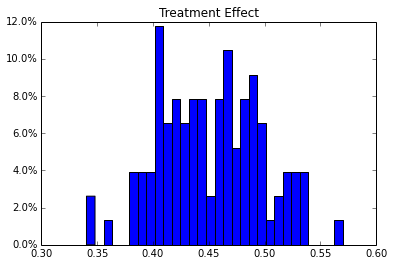

In [26]:
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.ticker import FuncFormatter
def to_percent(y, position):
    # Ignore the passed in position. This has the effect of scaling the default
    # tick locations.
    s = str(y)

    # The percent symbol needs escaping in latex
    if matplotlib.rcParams['text.usetex'] is True:
        return s + r'$\%$'
    else:
        return s + '%'
formatter = FuncFormatter(to_percent)
#Doing stuff with the previous distribution
plt.hist(distribution_response, 30,normed=True)
plt.gca().yaxis.set_major_formatter(formatter)
plt.title('Treatment Effect')
plt.show()


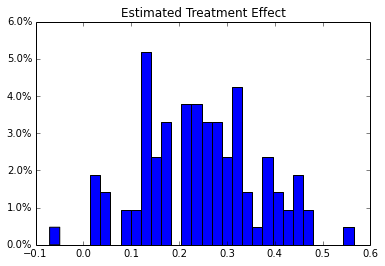

In [27]:
formatter = FuncFormatter(to_percent)
#Doing stuff with the previous distribution
plt.hist(distribution_estimation, 30, normed=True)
plt.gca().yaxis.set_major_formatter(formatter)
plt.title('Estimated Treatment Effect')
plt.show()

In [28]:
print np.mean(distribution_response)
print np.mean(distribution_estimation)

0.451913618542
0.244986746264
